# 3 layer Conv Encoder, LSTM Decoder. 30 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm1'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 30
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, y = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (638, 30, 25)
train_y shape (638, 7, 1)
dev_X shape (80, 30, 25)
dev_y shape (80, 7, 1)
test_X shape (80, 30, 25)
test_y shape (80, 7, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=96, kernel_size=3, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(num_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 64)            4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 96)            18528     
_________________________________________________________________
batch_normalization_2

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 638 samples, validate on 80 samples
Epoch 1/200
638/638 [==============================] - 6s 10ms/step - loss: 0.0307 - val_loss: 0.0058
Epoch 2/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 3/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 4/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 5/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 6/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 7/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/200
638/638 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 9/200
638/638 [==================

638/638 [==============================] - 1s 2ms/step - loss: 5.0865e-04 - val_loss: 0.0072
Epoch 77/200
638/638 [==============================] - 1s 2ms/step - loss: 4.7366e-04 - val_loss: 0.0070
Epoch 78/200
638/638 [==============================] - 1s 2ms/step - loss: 4.8700e-04 - val_loss: 0.0050
Epoch 79/200
638/638 [==============================] - 1s 2ms/step - loss: 4.8371e-04 - val_loss: 0.0047
Epoch 80/200
638/638 [==============================] - 1s 2ms/step - loss: 4.9886e-04 - val_loss: 0.0028
Epoch 81/200
638/638 [==============================] - 1s 2ms/step - loss: 5.1408e-04 - val_loss: 0.0032
Epoch 82/200
638/638 [==============================] - 1s 2ms/step - loss: 4.3759e-04 - val_loss: 0.0026
Epoch 83/200
638/638 [==============================] - 1s 2ms/step - loss: 4.8230e-04 - val_loss: 0.0038
Epoch 84/200
638/638 [==============================] - 1s 2ms/step - loss: 4.6510e-04 - val_loss: 0.0033
Epoch 85/200
638/638 [==============================] - 1s 

Epoch 153/200
638/638 [==============================] - 1s 2ms/step - loss: 3.2099e-04 - val_loss: 0.0039
Epoch 154/200
638/638 [==============================] - 1s 2ms/step - loss: 3.3020e-04 - val_loss: 0.0083
Epoch 155/200
638/638 [==============================] - 1s 2ms/step - loss: 2.8765e-04 - val_loss: 0.0097
Epoch 156/200
638/638 [==============================] - 1s 2ms/step - loss: 2.8074e-04 - val_loss: 0.0098
Epoch 157/200
638/638 [==============================] - 1s 2ms/step - loss: 2.9425e-04 - val_loss: 0.0080
Epoch 158/200
638/638 [==============================] - 1s 2ms/step - loss: 2.7860e-04 - val_loss: 0.0109
Epoch 159/200
638/638 [==============================] - 1s 2ms/step - loss: 2.8065e-04 - val_loss: 0.0104
Epoch 160/200
638/638 [==============================] - 1s 2ms/step - loss: 2.7491e-04 - val_loss: 0.0081
Epoch 161/200
638/638 [==============================] - 1s 2ms/step - loss: 2.7357e-04 - val_loss: 0.0066
Epoch 162/200
638/638 [==============

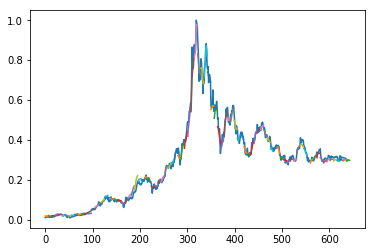

In [6]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

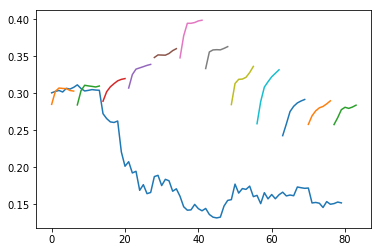

In [10]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

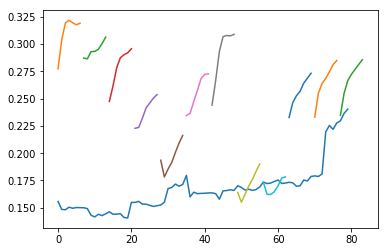

In [11]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [12]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.0032341976270340578
MSE Dev: 0.02108326506731819
MSE Test: 0.00974860137059623


In [13]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5384615384615384
Acc Dev: 0.3670886075949367
Acc Test: 0.5443037974683544


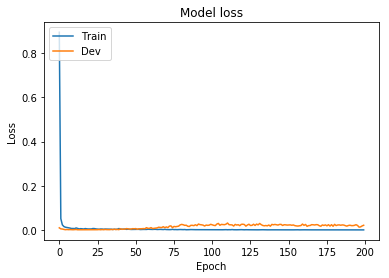

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()